In [9]:
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
from scipy.stats import zscore
import gzip
import os
import csv
from alive_progress import alive_bar
from collections import defaultdict
import time


In [10]:

from pyspark.sql import SparkSession
from pyspark.sql.functions import split, col, element_at, slice, size, regexp_extract, transform, when, explode, \
monotonically_increasing_id, map_from_arrays, lit, udf,collect_list, row_number, ceil, map_keys, expr, from_json
from pyspark.sql.types import ShortType, ArrayType, LongType, StringType
from pyspark.sql import types as T
from pyspark.conf import SparkConf
import pandas as pd

#path = 'C:/Users/bincl/BA-Thesis/Dataset/2gram/2_20000_nopos_ab.gz'
start_date = 1800
end_date = 2000
directory_3gram = 'C:/Users/bincl/BA-Thesis/Dataset/3gram/parquet/'
directory_2gram = 'C:/Users/bincl/BA-Thesis/Dataset/2gram/parquet/'

#spark = SparkSession.builder.config(conf=conf).appName('NgramSQL').getOrCreate()
spark = SparkSession.builder.appName('NgramSQL').getOrCreate()

df_3gram = spark.read.option("header","true").option("recursiveFileLookup","true").parquet(directory_3gram)   
#df_3gram.repartition(5) 


In [11]:

df_2gram = spark.read.option("header","true").option("recursiveFileLookup","true").parquet(directory_2gram)    

In [12]:
# if id set as default parameter then a list is given if not a spark dataframe is given as parameter df
def get_pd_df(df):
    matched = df['Data'] 
    matched_pandas_df = pd.Series(matched)
    matched_pandas_df.sort_index(inplace = True)

    matched_pandas_df.index.astype('int')
    numbers = list(range(start_date,end_date))
    numbers = map(str, numbers)
    matched_pandas_df = matched_pandas_df.reindex(numbers, fill_value= 0)
    return matched_pandas_df

def get_pd_df_from_string(suchstring, df):
    x = df.select(['Tokens', 'Data']).where(df.Tokens == suchstring).limit(1)
    matched = x.first()['Data']
    matched_pandas_df = pd.Series(matched)
    matched_pandas_df.sort_index(inplace = True)

    matched_pandas_df.index.astype('int')
    numbers = list(range(start_date,end_date))
    numbers = map(str, numbers)
    matched_pandas_df = matched_pandas_df.reindex(numbers, fill_value= 0)
    return matched_pandas_df

In [13]:
# deprecated zu langsam
def find_n_gram(direc, find):
    for filename in os.listdir(direc):
        f = os.path.join(direc, filename)
        # checking if it is a file
        if os.path.isfile(f):
            with gzip.open(f,'rt', encoding='utf-8') as input:
                str_arr_csv = input.readlines()
                for line in str_arr_csv:
                    token = line.split("\t")
                    if find == token[0]:
                        return line
                        
    return "line not found" 

def start_the_search(directory,search):
    result = find_n_gram(directory,search)
    
    if result == "line not found":
        print(result)
        exit()
    result = result.split("\t")
    lower_ngram = pd.Series(result[1:],dtype= "string", name = result[0])
    return lower_ngram

In [14]:
def getLowerLevelString(string):
   first, *middle, last = string.split()
   if len(middle) != 0:
        first = first + " " + ''.join(middle)
        last = ''.join(middle) + " " + last    
   return first, last

def MLR(token,data):
    y = data
    first,last = getLowerLevelString(token)
    first = get_pd_df_from_string(first,df_2gram)
    last = get_pd_df_from_string(last,df_2gram)
    X = pd.concat([first,last],axis=1)
    reg = LinearRegression()
    reg.fit(X, y) 
    return reg.coef_,reg.intercept_,X,y

def buildApproximation(c1,c2,basevalue,df):
    df = df.astype('float')
    
    df = df.fillna(0)
    
    df['scaledFirst'] = df.iloc[:,0].apply(lambda x: x * c1) 
    df['scaledLast'] = df.iloc[:,1].apply(lambda x: x * c2) 
    df['approximation'] = df['scaledFirst'] + df['scaledLast'] + basevalue
    return df

In [15]:
def compressWithError2gram(n,error):
    
    df_3_gram = df_3gram.orderBy("Sum", acending = False).head(n)
    result = []
    all = []
    sum = []
    firstN = range(0,n)
    
    with alive_bar(len(firstN), force_tty = True, bar = 'smooth') as bar:
        for i in firstN:
            df_file = df_3_gram[i]
            data = get_pd_df(df_file)
            token = df_file['Tokens']
            if not(data.eq(0).all()):
                coef,intercept,dfAprox,original = MLR(token,data)
                c1,c2 = coef
                df = buildApproximation(c1,c2,intercept,dfAprox)
                dfOriginal = pd.DataFrame()
                dfOriginal['values'] = original
                dfOriginal['values'] = dfOriginal['values'].apply(pd.to_numeric, errors='coerce')
                #dfOriginal= pd.to_numeric(dfOriginal)
                dfOriginal['zscore'] = zscore(dfOriginal)
                df['zscore'] = zscore(df['approximation'])
                sum.append(pd.to_numeric(dfOriginal['values']).sum()) 
                #sum.append(df_file['Sum']) 
                rmse = mean_squared_error(dfOriginal['zscore'], df['zscore'], squared = False)
                #rmse = mean_squared_error(dfOriginal, df['approximation'])
                if rmse <= error:
                    result.append([token,rmse,dfOriginal['values'],dfOriginal['zscore'],df['approximation'],df['zscore']]) 
                all.append(rmse)    
            bar()
    return result, all, sum


In [16]:
result, all, sum = compressWithError2gram(1000, 1)
print(sum)
print(all)
print(len(result))

on 14: on 23: ERROR:root:KeyboardInterrupt while sending command.
              Traceback (most recent call last):
                File "c:\Users\bincl\AppData\Local\Programs\Python\Python311\Lib\site-packages\py4j\java_gateway.py", line 1038, in send_command
                  response = connection.send_command(command)
                             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                File "c:\Users\bincl\AppData\Local\Programs\Python\Python311\Lib\site-packages\py4j\clientserver.py", line 511, in send_command
                  answer = smart_decode(self.stream.readline()[:-1])
                                        ^^^^^^^^^^^^^^^^^^^^^^
                File "c:\Users\bincl\AppData\Local\Programs\Python\Python311\Lib\socket.py", line 705, in readinto
                  return self._sock.recv_into(b)
                         ^^^^^^^^^^^^^^^^^^^^^^^
              KeyboardInterrupt


|▏⚠︎                                      | (!) 23/10000 [0%] in 1:44.8 (0.22/s) 


KeyboardInterrupt: 

In [ ]:
import pickle
import pandas as pd



# Saving the objects:
with open('rsults_3gram_1000.pkl', 'wb') as f:  
    pickle.dump([result, all, sum], f)

# Getting back the objects:



In [ ]:
with open('rsults_3gram_1000.pkl', 'rb') as f:  
    obj = pickle.load(f)
    f.close()
print(obj)   

[[['den Sektor der', 0.13190010162194585, 1800      0
1801      0
1802      0
1803      0
1804      0
       ... 
1995    123
1996    121
1997    125
1998    157
1999    187
Name: values, Length: 200, dtype: int64, 1800   -0.569273
1801   -0.569273
1802   -0.569273
1803   -0.569273
1804   -0.569273
          ...   
1995    0.963242
1996    0.938323
1997    0.988161
1998    1.386864
1999    1.760648
Name: zscore, Length: 200, dtype: float64, 1800     -1.734890
1801     -1.906378
1802     -1.906378
1803     -1.906378
1804     -1.820634
           ...    
1995    154.013317
1996    136.506389
1997    136.417620
1998    145.656943
1999    159.529538
Name: approximation, Length: 200, dtype: float64, 1800   -0.596074
1801   -0.598230
1802   -0.598230
1803   -0.598230
1804   -0.597152
          ...   
1995    1.361495
1996    1.141454
1997    1.140338
1998    1.256465
1999    1.430827
Name: zscore, Length: 200, dtype: float64], ['Erkenntnisse und Methoden', 0.28028285312358703, 1800      0
18

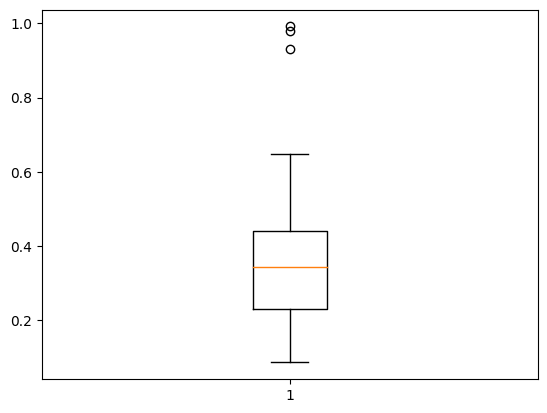

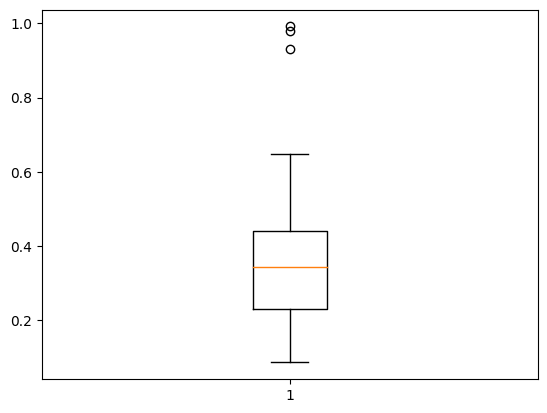

<AxesSubplot: >

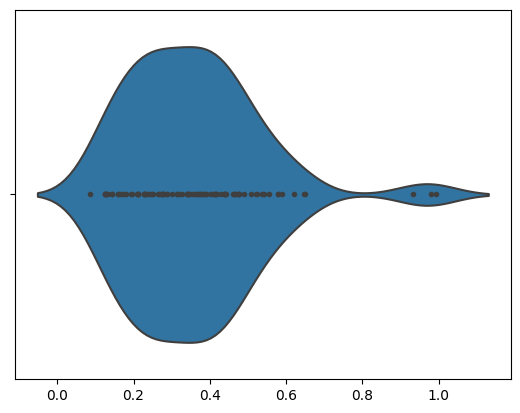

In [ ]:
plt.boxplot(all)
plt.show()
rmse_with_error = []

for i in result:
    rmse_with_error.append(i[1])
plt.boxplot(rmse_with_error)
plt.show()

import seaborn as sns

sns.violinplot(x= rmse_with_error, inner="point")

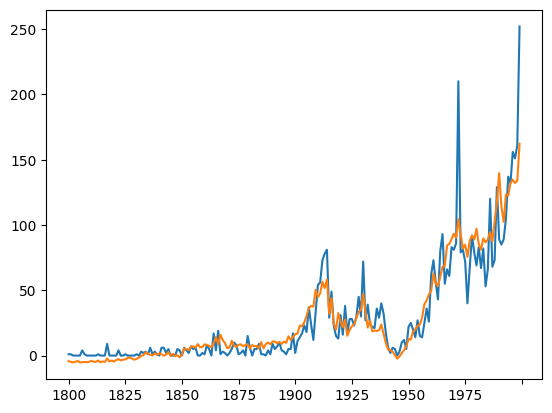

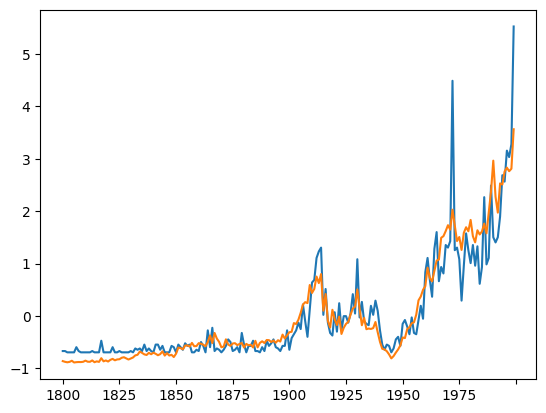

Der Markt der
0.3764926449868947


In [ ]:
n = 3
result[n][2].plot()
result[n][4].plot()
plt.show()
result[n][3].plot()
result[n][5].plot()
plt.show()
print(result[n][0])
print(result[n][1])


<AxesSubplot: >

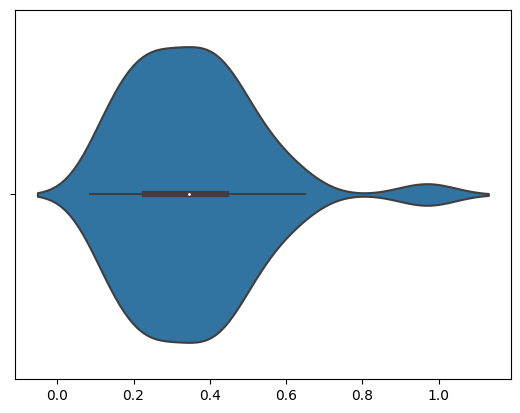

In [ ]:
sns.violinplot(x= all, inner_kws=dict(box_width=15, whis_width=2, color=".8"))

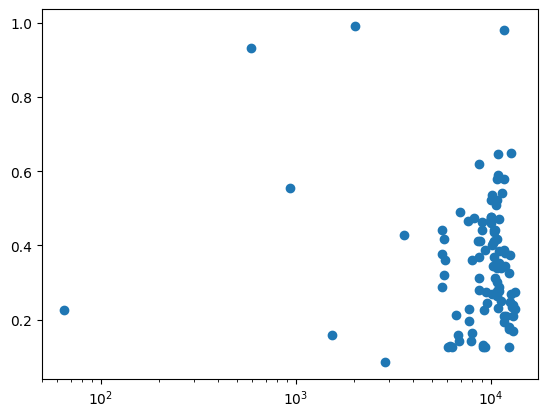

In [ ]:

plt.scatter(sum, all)
plt.xscale('log')
plt.show()